# Hopfield 🫠

https://towardsdatascience.com/hopfield-networks-neural-memory-machines-4c94be821073

To use an Hopfield Network for a Binary image classification task we stored in the network some labeled patterns and then predict the label of a new image with the label of the pattern to which it converges.

### Libraries

In [61]:
import utilities as ff
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import PIL
import PIL.Image
import utilities as ff
import tqdm
import random
import pygame
from scipy.spatial import distance

import tensorflow as tf
from tensorflow.keras import activations, layers, optimizers, losses

### Hopfield class

Definition of the Hopfield network class

In [2]:
class Hopfield_Net:  # network class
    # init ialize network variables and memory
    def __init__(self, input, state):

        
        # patterns for network training / retrieval
        self.memory = np.array(input)
        # single vs. multiple memories
        if self.memory.size > 1:
            self.n = self.memory.shape[1]
        else:
            self.n = len(self.memory)
        # network construction
        self.state = np.array(state)  # state vector
        self.weights = np.zeros((self.n, self.n))  # weights vector
        self.energies = []  # container for tracking of energy

        self.pointer = 0
        self.order = list(range(self.n))
        random.shuffle(self.order)
        
        self.is_over=False

    def network_learning(self):  # learn the pattern / patterns
        self.weights = (
            (1 / self.memory.shape[0]) * self.memory.T @ self.memory
        )  # hebbian learning
        np.fill_diagonal(self.weights, 0)

    def update_network_state(self, n_update):  # update network
        for _ in range(n_update): #update n neurons randomly

            self.rand_index = self.order[self.pointer]

            # Compute activation for randomly indexed neuron
            self.index_activation = np.dot(self.weights[self.rand_index, :], self.state)
            # threshold function for binary state change
            if self.index_activation < 0:
                self.state[self.rand_index] = -1
            else:
                self.state[self.rand_index] = 1

        self.pointer = (self.pointer + 1 ) % self.n

    def compute_energy(self):  # compute energy
        self.energy = -0.5 * np.dot(np.dot(self.state.T, self.weights), self.state)
        self.energies.append(self.energy)


### Dataset

Setting parameters.

In [3]:
batch_size = 1
img_height = 100
img_width = 100
color_mode='grayscale'
seed=42
data_dir = pathlib.Path("downloads\CatsDogs")

Downloading the dataset.

In [4]:
ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    color_mode=color_mode,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 23401 files belonging to 2 classes.


As a big dataset is not needed for this network we focus just on a small sample.

In [5]:
ds=ds.take(100)

We normalize the images to be flattened and with binary values.

In [6]:
normalization_layer = tf.keras.layers.Rescaling(scale=1.0/255, offset=-0.5001)

In [7]:
normalized_ds = ds.map(lambda x, y: (normalization_layer(x), y))

In [8]:
images=[]
labels=np.array([])
for batch in tqdm.tqdm(normalized_ds):
    #sobel=tf.image.sobel_edges(batch[0])
    #sobel_x=np.asarray(sobel[0,:,:,:,1])
    arr = np.squeeze(tf.math.sign(batch[0]))
    images.append(arr)
    labels=np.append(labels,(int(batch[1][0])))
images=np.array(images)
images=images.reshape((-1,10000))

100%|██████████| 100/100 [00:00<00:00, 132.02it/s]


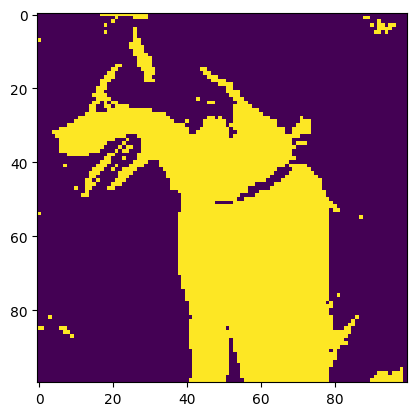

In [9]:
plt.imshow(images[3].reshape((100,100)))
plt.show()

### Testing step by step

Set in memories_list the images to be stored and in test_image the image to be tested.
Then initialize the network.

In [10]:
memories_list=images[:4]
test_index=27
test_image=images[test_index]
memories_list[0].shape

(10000,)

In [11]:
#initialize Hopfield object
H_Net = Hopfield_Net(memories_list, test_image)
H_Net.network_learning()

[]

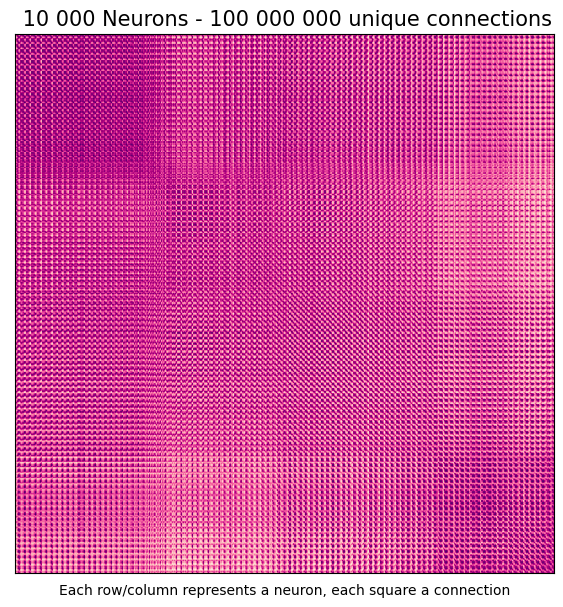

In [12]:
# plot weights matrix
plt.figure("weights", figsize=(10, 7))
plt.imshow(H_Net.weights, cmap="RdPu")  #
plt.xlabel("Each row/column represents a neuron, each square a connection")

plt.title(" 10 000 Neurons - 100 000 000 unique connections", fontsize=15)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

Compute the stable state.

In [13]:
while not H_Net.is_over:
    old_state=np.array(H_Net.state)
    for _ in range(100):
        H_Net.update_network_state(100)
    H_Net.compute_energy()
    if np.all(H_Net.state==old_state):
        H_Net.is_over=True

[]

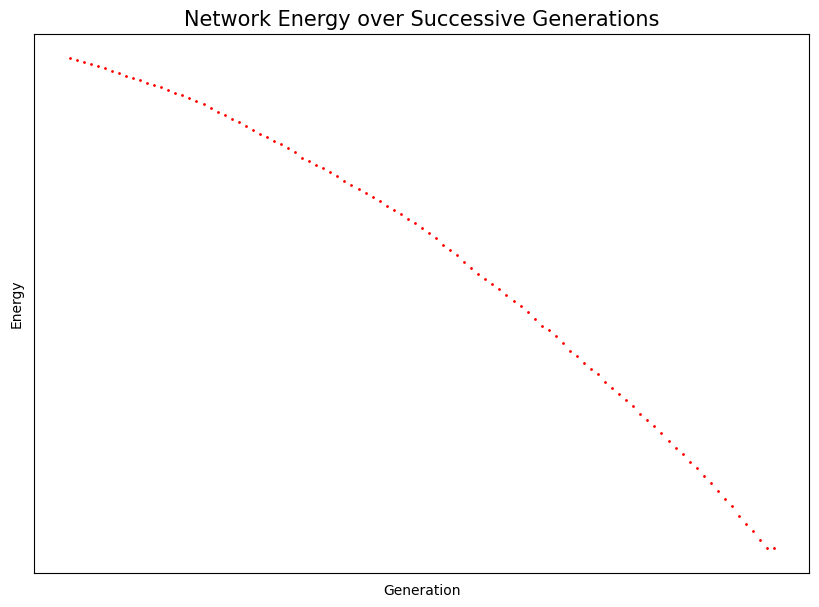

In [14]:
# plot energies
plt.figure("Energy", figsize=(10, 7))
x = np.arange(len(H_Net.energies))
plt.scatter(x, np.array(H_Net.energies), s=1, color="red")
plt.xlabel("Generation")
plt.ylabel("Energy")
plt.title("Network Energy over Successive Generations", fontsize=15)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

Tested image

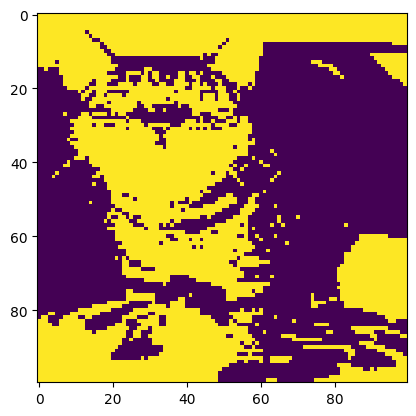

In [15]:
plt.imshow(test_image.reshape((100,100)))
plt.show()

Stable state reached

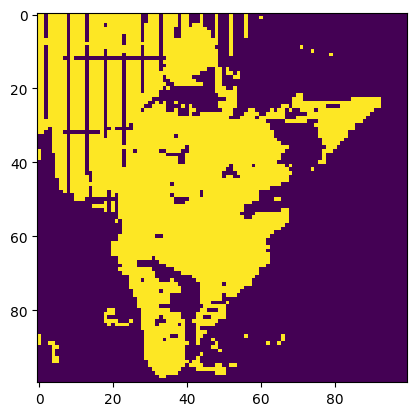

In [16]:
plt.imshow(H_Net.state.reshape((100,100)))
plt.show()

"binary Hopfield networks (BHNs) are prone to ‘spurious’ minima. If memories learned by a BHN are too similar, or if too many pattern vectors are learned, the network risks converging to an in-between memory, some combination of learned patterns; in other words, the network will fail to discriminate between patterns and becomes useless."

Check if it is a spurius state or if the network predicted well.

In [17]:
spurius_state=True
for i, image in enumerate(memories_list):
    if np.all(H_Net.state==image):
        if labels[i]!=labels[test_index]:
            print('error!')
        else:
            print('Predicted well!')
        spurius_state=False

if spurius_state==True:
    print('spurius state!')


Predicted well!


### Exploratory experiments

As any pattern stored define a stable state, this network should have always zero training error.

In [43]:
number_of_patterns=4
while True:
    training_and_test_indexis=random.sample(range(100), number_of_patterns*2)
    train_indexis=training_and_test_indexis[:number_of_patterns//2]
    test_indexis=training_and_test_indexis[-number_of_patterns//2:]
    #check if there are both cats and dogs in train and test
    if max([labels[j] for j in train_indexis])==1 and min([labels[j] for j in train_indexis])==0 and max([labels[j] for j in test_indexis])==1 and min([labels[j] for j in test_indexis])==0:
        break
print(train_indexis,test_indexis)

[16, 88] [17, 78]


In [46]:
memories_list=[images[i] for i in train_indexis]
memories_labels=[labels[i] for i in train_indexis]
test_images=[images[i] for i in test_indexis]
test_labels=[labels[i] for i in test_indexis]
print(memories_labels,test_labels)

[1.0, 0.0] [0.0, 1.0]


Train

In [20]:
n_errors=0
n_spurius_states=0

for index in train_indexis:
    
    #initialize
    H_Net = Hopfield_Net(memories_list, images[index])
    H_Net.network_learning()
    
    #convergence
    while not H_Net.is_over:
        old_state=np.array(H_Net.state)
        for _ in range(100):
            H_Net.update_network_state(100)
        if np.all(H_Net.state==old_state):
            H_Net.is_over=True
    
    #label check
    spurius_state=True
    for i, image in enumerate(memories_list):
        if np.all(H_Net.state==image): #find the image to which had converged
            if memories_labels[i]!=labels[index]:
                n_errors+=1
            spurius_state=False
    if spurius_state:
        n_spurius_states+=1

print('PERFORMANCE ON THE TRAINING SET:')
print(f'Number of errors: {n_errors}')
print(f'Number of spurius states reached: {n_spurius_states}')       
            


PERFORMANCE ON THE TRAINING SET:
Number of errors: 0
Number of spurius states reached: 0


Test

In [21]:
n_errors=0
n_spurius_states=0

for index in test_indexis:
    
    #initialize
    H_Net = Hopfield_Net(memories_list, images[index])
    H_Net.network_learning()
    
    #convergence
    while not H_Net.is_over:
        old_state=np.array(H_Net.state)
        for _ in range(100):
            H_Net.update_network_state(100)
        if np.all(H_Net.state==old_state):
            H_Net.is_over=True
    
    #label check
    spurius_state=True
    for i, image in enumerate(memories_list):
        if np.all(H_Net.state==image): #find the image to which had converged
            if memories_labels[i]!=labels[index]:
                n_errors+=1
            spurius_state=False
    if spurius_state:
        n_spurius_states+=1
        
print('PERFORMANCE ON THE TEST SET:')
print(f'Number of errors: {n_errors}')
print(f'Number of spurius states reached: {n_spurius_states}')  

PERFORMANCE ON THE TEST SET:
Number of errors: 1
Number of spurius states reached: 1


In practice, even with a small number of patterns stored there is the risk that a some of the learned pattern converge instead to a spurius pattern.

In [101]:
number_of_patterns=10
while True:
    training_and_test_indexis=random.sample(range(100), number_of_patterns*2)
    train_indexis=training_and_test_indexis[:number_of_patterns//2]
    test_indexis=training_and_test_indexis[-number_of_patterns//2:]
    #check if there are both cats and dogs in train and test
    if max([labels[j] for j in train_indexis])==1 and min([labels[j] for j in train_indexis])==0 and max([labels[j] for j in test_indexis])==1 and min([labels[j] for j in test_indexis])==0:
        break
print(train_indexis,test_indexis)

memories_list=[images[i] for i in train_indexis]
memories_labels=[labels[i] for i in train_indexis]
print(memories_labels)

[59, 74, 97, 82, 66] [54, 87, 12, 98, 76]
[1.0, 0.0, 1.0, 0.0, 0.0]


Train

In [64]:
n_errors=0
n_spurius_states=0

for index in train_indexis:
    
    #initialize
    H_Net = Hopfield_Net(memories_list, images[index])
    H_Net.network_learning()
    
    #convergence
    while not H_Net.is_over:
        old_state=np.array(H_Net.state)
        for _ in range(100):
            H_Net.update_network_state(100)
        if np.all(H_Net.state==old_state):
            H_Net.is_over=True
    
    #label check
    spurius_state=True
    for i, image in enumerate(memories_list):
        if np.all(H_Net.state==image): #find the image to which had converged
            if memories_labels[i]!=labels[index]:
                n_errors+=1
            spurius_state=False
    if spurius_state:
        n_spurius_states+=1

print('PERFORMANCE ON THE TRAINING SET:')
print(f'Number of errors: {n_errors}')
print(f'Number of spurius states reached: {n_spurius_states}')  

PERFORMANCE ON THE TRAINING SET:
Number of errors: 0
Number of spurius states reached: 0


Test

In [65]:
n_errors=0
n_spurius_states=0

for index in test_indexis:
    
    #initialize
    H_Net = Hopfield_Net(memories_list, images[index])
    H_Net.network_learning()
    
    #convergence
    while not H_Net.is_over:
        old_state=np.array(H_Net.state)
        for _ in range(100):
            H_Net.update_network_state(100)
        if np.all(H_Net.state==old_state):
            H_Net.is_over=True
    
    #label check
    spurius_state=True
    for i, image in enumerate(memories_list):
        if np.all(H_Net.state==image): #find the image to which had converged
            if memories_labels[i]!=labels[index]:
                n_errors+=1
            spurius_state=False
    if spurius_state:
        n_spurius_states+=1
        
print('PERFORMANCE ON THE TEST SET:')
print(f'Number of errors: {n_errors}')
print(f'Number of spurius states reached: {n_spurius_states}')  

PERFORMANCE ON THE TEST SET:
Number of errors: 1
Number of spurius states reached: 4


It seems necessary to choose the patterns stored trying to minimizing the risk of spurius states. To do so the patterns stored need to be as dissimilar as possible.

So, we define an enreached algorithm using an Hopfield Network for binary image classification:

It take as inputs a training set of labeled images.
It has one parameters: **p** that is the number of patterns to be stored >=2.

First it choose **p** images from the training set, ensuring that there is at least one pattern for each label and maximizing the dissimilarity examples.

Then it stored these patterns with an Hopfield Network.

In [108]:
def pattern_chooser(training_images,training_labels,p):
    patterns=training_images
    patterns_labels=training_labels
    
    while len(patterns) > p:
        
        # build dinstance matrix
        n=len(patterns)
        dists = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                dists[i][j] = distance.hamming(training_images[i], training_images[j])
        np.fill_diagonal(dists, 1)
        
        label0=patterns_labels[np.where(dists == dists.min())[0][0]]
        label1=patterns_labels[np.where(dists == dists.min())[0][1]]
        
        #delete the pattern with the most represented label
        if patterns_labels.count(label0)>=patterns_labels.count(label1):
            del patterns[np.where(dists == dists.min())[0][0]]
            del patterns_labels[np.where(dists == dists.min())[0][0]]
        elif patterns_labels.count(label0)<patterns_labels.count(label1):
            del patterns[np.where(dists == dists.min())[0][1]]
            del patterns_labels[np.where(dists == dists.min())[0][1]]
        
        '''
        NOTE: this procedure ensure that at least one pattern per label is keeped as long  as p>=2
        
        PROOF: 
        this procedure delete one pattern at time
        and if there is just one pattern with a label value it can't be deleted as:
        its label count is 1 so:
        or the other label has a higher count than one,
        or it already reach the minimum number of patterns left that is 2 and will not delete any pattern
        '''     
    
    return patterns,patterns_labels

### Hyperparameter tuning

### Risk estimation

### Animation

In [155]:
#parameters for pygame

# Draw it all out, updating board each update iteration
cellsize = 5
img_size = 100

pygame.init()  # initialize pygame
# set dimensions of board and cellsize -  28 X 28  ~ special display surface
surface = pygame.display.set_mode((img_size * cellsize, img_size * cellsize))
pygame.display.set_caption("   ")

('display Surface quit',)


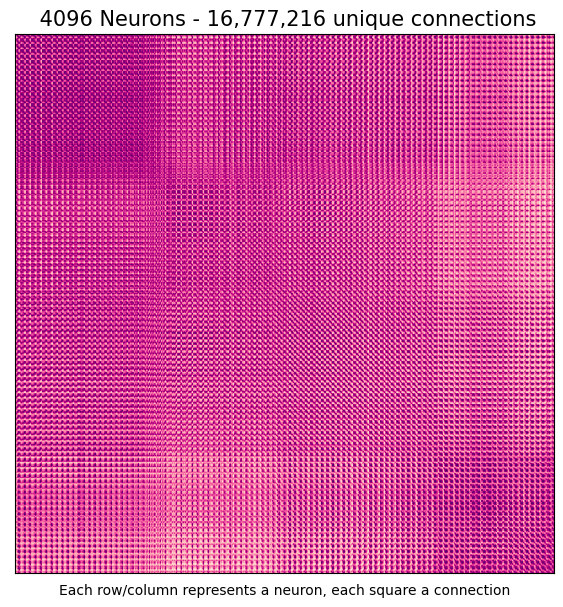

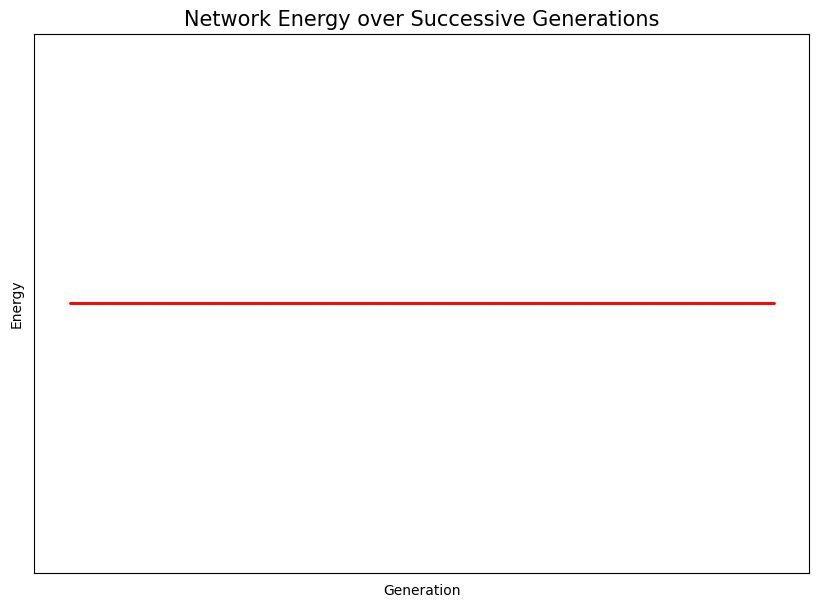

In [156]:
# kill pygame if user exits window
Running = True
# main animation loop
try:
    while Running:
        for event in pygame.event.get():
            pygame.time.wait(1)
            if event.type == pygame.QUIT:
                Running = False

                # plot weights matrix
                plt.figure("weights", figsize=(10, 7))
                plt.imshow(H_Net.weights, cmap="RdPu")  #
                plt.xlabel("Each row/column represents a neuron, each square a connection")

                plt.title(" 4096 Neurons - 16,777,216 unique connections", fontsize=15)
                plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

                # plot energies
                plt.figure("Energy", figsize=(10, 7))
                x = np.arange(len(H_Net.energies))
                plt.scatter(x, np.array(H_Net.energies), s=1, color="red")
                plt.xlabel("Generation")
                plt.ylabel("Energy")
                plt.title("Network Energy over Successive Generations", fontsize=15)
                plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

                # quit pygame
                pygame.quit()

        cells = H_Net.state.reshape(img_size, img_size).T

        # fills surface with color
        surface.fill((211, 211, 211))

        # loop through network state array and update colors for each cell
        for r, c in np.ndindex(cells.shape):  # iterates through all cells in cells matrix
            if cells[r, c] == -1:
                col = (135, 206, 250)

            elif cells[r, c] == 1:
                col = (0, 0, 128)

            else:
                col = (255, 140, 0)
            pygame.draw.rect(
                surface, col, (r * cellsize, c * cellsize, cellsize, cellsize)
            )  # draw new cell_

        # update network state
        H_Net.update_network_state(100)
        H_Net.compute_energy()
        pygame.display.update()  # updates display from new .draw in update function
except Exception as inst:
    print(inst.args)
